In [1]:
pip install summa

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


라이브러리 버전을 확인

In [3]:
#라이브러리 버전을 확인
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from summa.summarizer import summarize
import matplotlib.pyplot as plt


## Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

sunnysai12345/News_Summary[https://github.com/sunnysai12345/News_Summary]


In [5]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [6]:
data.sample(10)

,headlines,text
68185,Scientists name new spider species after Obama...,US-based researchers have discovered 15 new sp...
96084,1.8k govt appointments secured using fake cast...,"As many as 1,832 appointments in government de..."
46136,Drunk Canadian athlete steals car at Winter Ol...,"Canadian skier Dave Duncan, his wife and coach..."
88061,US inks $110 billion military deals with Saudi...,During his first overseas trip as US President...
54003,Maha CM orders judicial inquiry into Bhima Kor...,Maharashtra CM Devendra Fadnavis has ordered a...
66918,China issues advisory for citizens travelling ...,China has issued a new advisory for its citize...
29278,Sunidhi Chauhan shares first picture of her son,Sharing her son's first picture on social medi...
34563,Gore kar sakte hain to hum bhi: Sehwag in NatW...,After England managed to put up a total of 325...
57820,Solar capacity of airports may be doubled in 5...,Civil Aviation Minister Ashok Gajapathi Raju h...
51633,6-yr-old boy stabbed by senior in bathroom at ...,A six-year-old boy was stabbed with a knife on...


## Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.


평가문항
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.

상세기준

분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

In [7]:
# 필요한 컬럼 선택
data = data[['text', 'headlines']]

# 데이터 샘플 확인
data.head()

,text,headlines
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


In [8]:
#중복 샘플과 NULL 값이 존재하는 샘플 제거
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [9]:
#데이터프레임에 Null 값이 있는지 확인
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))
print(data.isnull().sum())

전체 샘플수 : 98360
text         0
headlines    0
dtype: int64


텍스트 정규화와 불용어 제거

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


In [12]:
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')





[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# 전처리 적용
data['cleaned_text'] = data['text'].apply(lambda x: preprocess_sentence(x, True))
data['cleaned_headlines'] = data['headlines'].apply(lambda x: preprocess_sentence(x, False))


In [14]:
data.head()

,text,headlines,cleaned_text,cleaned_headlines
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim...",speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...


In [15]:
data['text'] = data['cleaned_text']
data['headlines'] = data['cleaned_headlines']


In [16]:
# 빈 값을 Null 값으로 변환
data.isnull().sum()

# 전체 샘플 수 확인
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 샘플의 최대 길이 정하기

Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


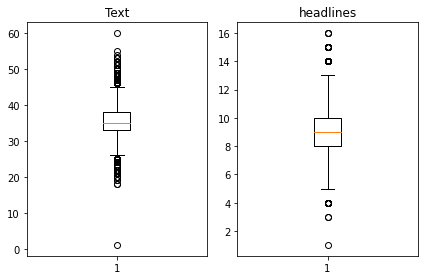

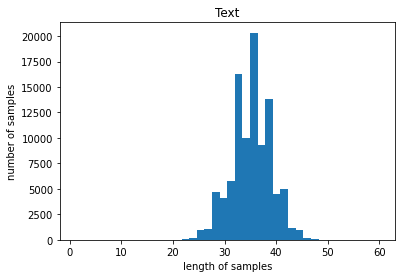

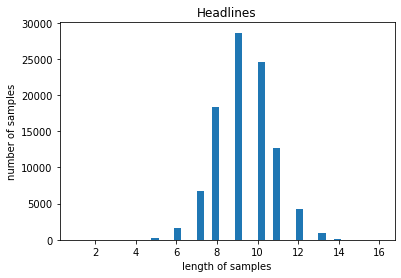

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
# 길이 임의 제한
text_max_len = 50
headlines_max_len = 16

In [21]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


In [22]:
#text와 headlines를 text_max_len과 summary_max_len의 길이보다 큰 샘플을 제외

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98346


In [24]:
# healine 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,text,headlines,cleaned_text,cleaned_headlines,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


훈련 데이터와 테스트 데이터를 분리
우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성

In [25]:
# 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[70366 38092 38399 ... 15331  8378  5020]


In [26]:
#정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]


n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19669


### 훈련 데이터와 테스트 데이터를 분리

In [35]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78677
훈련 레이블의 개수 : 78677
테스트 데이터의 개수 : 19669
테스트 레이블의 개수 : 19669


단어 집합(vocabulary) 만들기 및 정수 인코딩
이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꿈

In [36]:
#Keras의 토크나이저를 사용
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [37]:
# 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69566
등장 빈도가 6번 이하인 희귀 단어의 수: 47370
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22196
단어 집합에서 희귀 단어의 비율: 68.09360894689934
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4783918629907014


In [38]:
src_vocab = 11700
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 11700으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [39]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[266, 1477, 1217, 928, 573, 3568, 3568, 10464, 1342, 60, 3102, 3987, 3987, 1558, 135, 4128, 3386, 2672, 203, 229, 149, 501, 2788, 5045, 355, 3618, 2491, 8403, 461, 6010, 2143], [9450, 353, 3, 13, 3794, 8404, 3846, 2471, 5091, 8990, 3257, 940, 19, 195, 1571, 9641, 2337, 9450, 2492, 82, 3196, 1637, 556, 3510, 19, 195, 8404, 34, 3846, 125, 44, 368, 5, 16], [5, 5406, 185, 633, 4747, 938, 50, 10696, 949, 972, 329, 1380, 248, 29, 3, 77, 5660, 64, 104, 1766, 3741, 10696, 329, 1961, 847, 15, 1053, 574]]


In [40]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [41]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30105
등장 빈도가 5번 이하인 희귀 단어의 수: 19703
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10402
단어 집합에서 희귀 단어의 비율: 65.44760006643415
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.648947694403249


In [42]:
tar_vocab = 4600
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 144, 79, 18, 1202, 6, 517], [1, 29, 228, 2447, 17, 1635], [1, 212, 278, 15, 1466, 240, 839], [1, 1652, 897, 464, 1347, 3046, 234], [1, 598, 2499, 6, 2312, 217, 4, 1390, 451]]
target
decoder  [[144, 79, 18, 1202, 6, 517, 2], [29, 228, 2447, 17, 1635, 2], [212, 278, 15, 1466, 240, 839, 2], [1652, 897, 464, 1347, 3046, 234, 2], [598, 2499, 6, 2312, 217, 4, 1390, 451, 2]]


##패딩하기

In [44]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')


## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.



In [45]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AdditiveAttention

# 파라미터 설정
embedding_dim = 128
hidden_size = 256
text_max_len = 50
summary_max_len = 8

# 인코더
encoder_inputs = Input(shape=(text_max_len,))
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])


# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()




Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1497600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [46]:
# 학습
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)



Epoch 1/50
308/308 [==============================] - 36s 94ms/step - loss: 3.7100 - val_loss: 3.4042
Epoch 2/50
308/308 [==============================] - 28s 92ms/step - loss: 3.2564 - val_loss: 3.1405
Epoch 3/50
308/308 [==============================] - 29s 94ms/step - loss: 3.0234 - val_loss: 2.9275
Epoch 4/50
308/308 [==============================] - 30s 96ms/step - loss: 2.8336 - val_loss: 2.7851
Epoch 5/50
308/308 [==============================] - 30s 99ms/step - loss: 2.6891 - val_loss: 2.6893
Epoch 6/50
308/308 [==============================] - 31s 101ms/step - loss: 2.5745 - val_loss: 2.6105
Epoch 7/50
308/308 [==============================] - 31s 100ms/step - loss: 2.4794 - val_loss: 2.5529
Epoch 8/50
308/308 [==============================] - 31s 100ms/step - loss: 2.3980 - val_loss: 2.4994
Epoch 9/50
308/308 [==============================] - 31s 100ms/step - loss: 2.3270 - val_loss: 2.4658
Epoch 10/50
308/308 [==============================] - 31s 100ms/step - loss: 

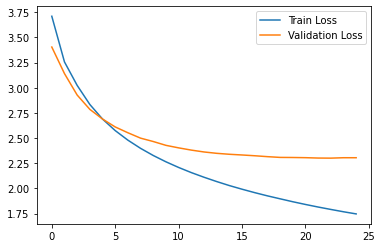

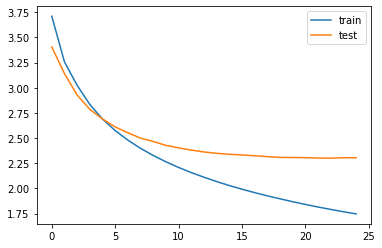

In [47]:
# 손실 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

#시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전 준비

In [48]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도 진행

In [49]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


평가문항

2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.

상세기준

모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.

In [50]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [51]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [52]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환

def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.



평가문항

 Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.

 상세기준

 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.

In [53]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : part viral year challenge filmmaker karan johar took instagram share two pictures one taken decade high hair still filmmaker wrote caption hope feeling karan added 
실제 요약 : still karan shares year challenge pic 
예측 요약 :  am not met johar on pic with


원문 : uttar pradesh provincial armed authorities planned award personnel sport big additional director general kumar singh said personnel allowance maintaining increased month added boost one personality increases confidence policeman 
실제 요약 : uttar pradesh plans to award policemen with big 
예측 요약 :  up govt to give up to kin


원문 : former us president barack obama visiting indonesia family visited bali set meet indonesian president obama six moved jakarta mother married indonesian returned official visit president michelle time brought daughters well 
실제 요약 : obama returns to indonesia for family 
예측 요약 :  obama and obama to visit us


원문 : prime minister narendra modi addressed world economic forum switzerland davos congress preside

실제 헤드라인과 비교하여 원문의 단어들은 포함 되엇으나, 문법적으로나 의미적으로 다른 부분이 있음

## Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요

In [54]:
pip install summa

Note: you may need to restart the kernel to use updated packages.


In [60]:
import requests
from summa.summarizer import summarize

In [61]:
# 추출적 요약 예시
text1 = data['text'][0]

In [63]:
text1

'saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'

In [62]:
print('Summary:')
print(summarize(text1, ratio=0.005))

Summary:



In [64]:
print('Summary:')
print(summarize(text1, ratio=0.005, split=True))

Summary:
[]


In [65]:
print('Summary:')
print(summarize(text1, words=50))

Summary:



In [66]:

# 요약을 수행하는 함수 정의
def generate_summary(text, ratio=0.1):
    try:
        # summa로 요약 생성
        return summarize(str(text), ratio=ratio)
    except ValueError:  # 빈 텍스트 처리
        return "Summary not generated."

# 각 행에 대해 추출적 요약 생성
data['generated_summary'] = data['text'].apply(lambda x: generate_summary(x, ratio=0.1))

# 비교 테이블 생성
comparison_table = data[['text', 'headlines', 'generated_summary']]

# 결과 출력
print(comparison_table.head())

                                                text  \
0  saurav kant alumnus upgrad iiit pg program mac...   
1  kunal shah credit card bill payment platform c...   
2  new zealand defeated india wickets fourth odi ...   
3  aegon life iterm insurance plan customers enjo...   
4  speaking sexual harassment allegations rajkuma...   

                                           headlines generated_summary  
0  upgrad learner switches to career in ml al wit...                    
1  delhi techie wins free food from swiggy for on...                    
2  new zealand end rohit sharma led india match w...                    
3  aegon life iterm insurance plan helps customer...                    
4  have known hirani for yrs what if metoo claims...                    


In [67]:
#결과를 파일로 저장
comparison_table.to_csv('comparison_table.csv', index=False, encoding='utf-8')